In [2]:
# Import packages
import pandas as pd
import numpy as np
#from w2v_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re # regular expresson package
# Import NLP packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Import sklearn packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import pickle
# Import keras for NN implementation
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [3]:
## vectorization CountVectorizer()
with open('train_data.pkl', 'rb') as f:
      X_tr, y_tr = pickle.load(f)
        
with open('test_data.pkl', 'rb') as f:
      X_te, y_te = pickle.load(f)
        
## vectorization TfidfVectorizer()
with open('train_data2.pkl', 'rb') as f:
      X_tr2, y_tr2 = pickle.load(f)
        
with open('test_data2.pkl', 'rb') as f:
      X_te2, y_te2 = pickle.load(f)

In [4]:
# Load the data for tokenizer
data = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data.columns = ['label', 'text']
print("The data has", data.shape[0], "row(s) and ", data.shape[1], "column(s)")
data.head()

The data has 5572 row(s) and  2 column(s)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Get a word count and unique word count of the text
data.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

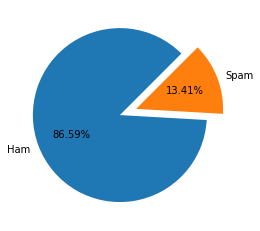

In [6]:
x = data.groupby('label').describe()
# Get the number of ham and spam
num_ham = x['text']['count'][0]
num_spam = x['text']['count'][1]
# plot a pie chart to show how many spams and hams
plt.pie([num_ham, num_spam],labels=["Ham", "Spam"],explode=(0,0.2),autopct='%1.2f%%',startangle=45)
plt.show()

In [7]:
data

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
# Encode ham and spam into binary number
le = LabelEncoder()
data.label = le.fit_transform(data.label)
data

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


We are going to try lemmatization and stopword removal. However, conventional processing techniques are not going to work well with a SMS corpus. The texts have a lot of shortened words and abbreviations. Ideally, we have to implement a customized normalization of text.

In [9]:
# Set up the english stopword library
total_stopwords = set([word.replace("'",'') for word in stopwords.words('english')]) 
# Call the lemmatizer class
lemma = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.replace("'",'') # Remove apostrophe
    text = re.sub('[^a-zA-Z]',' ',text) # 
    words = text.split() # Split the text into words by looking at the space between the texts
    # Stem the words and also remove stopwords
    words = [lemma.lemmatize(word) for word in words if (word not in total_stopwords) and (len(word)>1)] # Remove stop words
    # Put the clean words back together as a text message
    text = " ".join(words)
    return text

In [10]:
# Clean the text
data.text = data.text.apply(preprocess_text)
data

,label,text
0,0,go jurong point crazy available bugis great wo...
1,0,ok lar joking wif oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,dun say early hor already say
4,0,nah dont think go usf life around though
...,...,...
5567,1,nd time tried contact pound prize claim easy c...
5568,0,going esplanade fr home
5569,0,pity mood suggestion
5570,0,guy bitching acted like id interested buying s...


In [11]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.15, stratify=data.label)

# Word Embedding approach with RNN

In the tokenization layer, they maintain a dictionary that map a word to an index. For example, dog -> 0, cat->1, and so on.

Embedding layer will internally maintain a lookup table, and the lookup table will map the index/token to a vector, and that vector is what represent the word in the higher dimensional space. (See details for tokenizer: https://towardsdatascience.com/spam-filtering-system-with-deep-learning-b8070b28f9e0)

Summary of the process: Email -> Token -> LookUp table -> Vector

## 1. GRU with Vanila Embedding From Scratch

-The idea of Bidirectional is simple yet powerful. What it does is having two LSTM network instead of one.

-For the first LSTM network, it will feed in the input sequence as per normal. For the second LSTM network, it will reverse the input sequence and feed in to the LSTM network. The output of these two networks will be merged and then passed on to the next layer.

-The intuition behind Bidirectional is that, for some of the sentences, the context information is at the end of the sentence.

## a. GRU with data based on count-vectorized data

In [5]:
inp = Input(shape=(9376,))
# Embedding layer
# Arg: input_dim: This is the size of the vocabulary in the text data. 
# For example, if your data is integer encoded to values between 0-10, 
# then the size of the vocabulary would be 11 words.
# Arg: output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. 
# For example, it could be 32 or 100 or even larger. Test different values for your problem.
# Arg: input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 
# For example, if all of your input documents are comprised of 1000 words, this would be 1000.
x = Embedding(9376, 10)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
history1 = model1.fit(X_tr, y_tr, batch_size=512, epochs=20, validation_data=(X_te, y_te))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9376)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 9376, 10)          93760     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 9376, 128)         28800     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 4520s 954ms/step - loss: 0.6691 - accuracy: 0.8469 - val_loss: 0.6255 - val_accuracy: 0.8708
Epoch 2/20
4736/4736 [==============================] - 3928s 829ms/step - loss: 0.5792 - accuracy: 0.8651 - val_loss: 0.4913 - val_accuracy: 0.8708
Epoch 3/20
4736/4736 [==============================] - 3885s 820ms/step - loss: 0.4340 - accuracy: 0.8651 - val_loss: 0.3935 - val_accuracy: 0.8708
Epoch 4/20
4736/4736 [==============================] - 3903s 824ms/step - loss: 0.4061 - accuracy: 0.8651 - val_loss: 0.3897 - val_accuracy: 0.8708
Epoch 5/20
4736/4736 [==============================] - 3696s 780ms/step - loss: 0.4013 - accuracy: 0.8651 - val_loss: 0.3849 - val_accuracy: 0.8708
Epoch 6/20
4736/4736 [==============================] - 3801s 803ms/step - loss: 0.3997 - accuracy: 0.8651 - val_loss: 0.3853 - val_accuracy: 0.8708
Epoch 7/20
4736/4736 [==============================] - 390

KeyboardInterrupt: 

In [10]:
with open('rnn_model/gru_count_scratch_embedding.pkl','wb') as f:
    pickle.dump((model1), f)

## b. GRU with data based on vertorized data using Tokenizer()

In [14]:
## some config values 
embed_size = 100 # how dimension of the word vector we would like to set
max_len = x_train.apply(lambda str: len(str.split())).max() # max number of words

In [15]:
tok = Tokenizer()
tok.fit_on_texts(x_train)
# Get how many unique words to use (i.e num rows in embedding vector)
vocab_size = len(tok.word_index) + 1

[[   0    0    0 ...  155   69  659]
 [   0    0    0 ...   18   26   16]
 [   0    0    0 ...  367 1730   46]
 ...
 [   0    0    0 ...  376  209  150]
 [   0    0    0 ...   11  161  147]
 [   0    0    0 ...  377  118    1]]


In [17]:
# Convect each text message to a vector of numbers based on the order of the word
x_train_features = np.array(tok.texts_to_sequences(x_train))
x_test_features = np.array(tok.texts_to_sequences(x_test))
# ensure that all sequences in a list have the same length by padding 0 in the front for shorter sentences
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [23]:
inp = Input(shape=(max_len,))
# Embedding layer
# Arg: input_dim: This is the size of the vocabulary in the text data. 
# For example, if your data is integer encoded to values between 0-10, 
# then the size of the vocabulary would be 11 words.
# Arg: output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. 
# For example, it could be 32 or 100 or even larger. Test different values for your problem.
# Arg: input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 
# For example, if all of your input documents are comprised of 1000 words, this would be 1000.
x = Embedding(vocab_size, embed_size)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
# Add global max pooling layer
x = GlobalMaxPool1D()(x)
# Add a hidden layer with 16 nodes
x = Dense(16, activation="relu")(x)
# Add a dropout layer
x = Dropout(0.1)(x)
# Output a binary class using sigmoid function
x = Dense(1, activation="sigmoid")(x)
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 74)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 74, 100)           648900    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 74, 128)           63360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17  

In [26]:
history2 = model2.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.6676 - accuracy: 0.7690 - val_loss: 0.6222 - val_accuracy: 0.8660
Epoch 2/20
4736/4736 [==============================] - 8s 2ms/step - loss: 0.5707 - accuracy: 0.8659 - val_loss: 0.4771 - val_accuracy: 0.8660
Epoch 3/20
4736/4736 [==============================] - 8s 2ms/step - loss: 0.4158 - accuracy: 0.8659 - val_loss: 0.3839 - val_accuracy: 0.8660
Epoch 4/20
4736/4736 [==============================] - 8s 2ms/step - loss: 0.3619 - accuracy: 0.8659 - val_loss: 0.3268 - val_accuracy: 0.8660
Epoch 5/20
4736/4736 [==============================] - 8s 2ms/step - loss: 0.2980 - accuracy: 0.8672 - val_loss: 0.2370 - val_accuracy: 0.8696
Epoch 6/20
4736/4736 [==============================] - 9s 2ms/step - loss: 0.1759 - accuracy: 0.9409 - val_loss: 0.0999 - val_accuracy: 0.9785
Epoch 7/20
4736/4736 [==============================] - 9s 2ms/step - loss: 0.0677 - acc

In [30]:
with open('rnn_model/gru_tokenizer_scratch_embedding.pkl','wb') as f:
    pickle.dump((model2), f)

array([[2.51144171e-04],
       [2.91168690e-04],
       [2.71052122e-04],
       [1.24692917e-04],
       [1.06781721e-04],
       [1.00466609e-03],
       [7.48038292e-05],
       [2.30044127e-04],
       [1.66594982e-04],
       [1.22278929e-04],
       [9.61422920e-05],
       [1.39176846e-04],
       [2.28020549e-03],
       [6.69986010e-04],
       [4.90814447e-04],
       [1.05708838e-04],
       [2.03368068e-03],
       [6.96003437e-04],
       [6.99728727e-04],
       [1.89185143e-04],
       [8.15391541e-05],
       [3.19123268e-04],
       [2.53051519e-04],
       [5.31703234e-04],
       [9.99755740e-01],
       [3.50743532e-04],
       [5.42491674e-03],
       [2.57849693e-04],
       [2.90900469e-04],
       [1.55478716e-04],
       [9.98746395e-01],
       [1.20693445e-03],
       [1.54018402e-04],
       [1.72674656e-04],
       [2.28106976e-04],
       [3.06546688e-04],
       [9.41574574e-04],
       [1.20997429e-04],
       [1.95562840e-04],
       [1.43110752e-04],


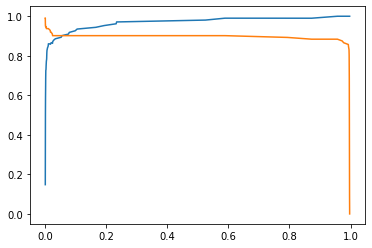

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       724
           1       0.91      0.90      0.91       112

    accuracy                           0.97       836
   macro avg       0.95      0.94      0.95       836
weighted avg       0.97      0.97      0.97       836



,Predicted 0,Predicted 1
Actual 0,714,10
Actual 1,11,101


In [74]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]

print(classification_report(y_test, y_pred > crossover_cutoff))

m_confusion_test = confusion_matrix(y_test, y_pred > crossover_cutoff)
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))



## c. GRU with td-idf vectorized data

In [12]:
# Explore Term Frequency Inverse Document Frequency (TF-IDF) (Source: )
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train_vec = vectorizer.transform(x_train).toarray()
x_test_vec = vectorizer.transform(x_test).toarray()

NameError: name 'x_train_features' is not defined

In [ ]:
inp = Input(shape=(x_train_vec.shape[1],))
# Embedding layer
# Arg: input_dim: This is the size of the vocabulary in the text data. 
# For example, if your data is integer encoded to values between 0-10, 
# then the size of the vocabulary would be 11 words.
# Arg: output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. 
# For example, it could be 32 or 100 or even larger. Test different values for your problem.
# Arg: input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 
# For example, if all of your input documents are comprised of 1000 words, this would be 1000.
x = Embedding(x_train_vec.shape[1], 100)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model3 = Model(inputs=inp, outputs=x)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
history3 = model3.fit(x_train_vec, y_train, batch_size=512, epochs=20, validation_data=(x_test_vec, y_test))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6510)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 6510, 100)         651000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6510, 128)         63360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4736 samples, validate on 836 samples
Epoch 1/20
 512/4736 [==>...........................] - ETA: 1:04:42 - loss: 0.7078 - accuracy: 0.1367

In [ ]:
inp = Input(shape=(9376,))
# Embedding layer
# Arg: input_dim: This is the size of the vocabulary in the text data. 
# For example, if your data is integer encoded to values between 0-10, 
# then the size of the vocabulary would be 11 words.
# Arg: output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. 
# For example, it could be 32 or 100 or even larger. Test different values for your problem.
# Arg: input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 
# For example, if all of your input documents are comprised of 1000 words, this would be 1000.
x = Embedding(9376, 10)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model3 = Model(inputs=inp, outputs=x)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
history1 = model3.fit(X_tr, y_tr, batch_size=512, epochs=20, validation_data=(X_te, y_te))

## 2. GRU with GloVe pre-trained embedding layer

In [37]:
# Empty dictionary
embeddings_index = dict()
f = open('glove.6B.300d.txt')
# Write pretrained word embedding layer to a dictoray
for line in f:
    # split up word and the vector
    values = line.split()
    # Get the word
    word = values[0]
    # Get the word 
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [38]:
# create a weight matrix for words in training docs
# We can set our parameter instead of 300, vocab_size is how many tokens we have assigned, or the number of words
embedding_matrix = np.zeros((vocab_size, 300))
# Loop through the words and index and create a embedding matrix using each word vector
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
inp = Input(shape=(max_len,))
# Embedding layer
# Arg: input_dim: This is the size of the vocabulary in the text data. 
# For example, if your data is integer encoded to values between 0-10, 
# then the size of the vocabulary would be 11 words.
# Arg: output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. 
# For example, it could be 32 or 100 or even larger. Test different values for your problem.
# Arg: input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 
# For example, if all of your input documents are comprised of 1000 words, this would be 1000.
x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inp)
# Bidirectional with Graded Recurrent Unit
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model4 = Model(inputs=inp, outputs=x)
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 74)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 74, 300)           1946700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 74, 128)           140160    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17  

In [70]:
history4 = model4.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

Train on 4736 samples, validate on 836 samples
Epoch 1/20
4736/4736 [==============================] - 12s 2ms/step - loss: 0.5286 - accuracy: 0.7633 - val_loss: 0.3796 - val_accuracy: 0.8648
Epoch 2/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.3331 - accuracy: 0.8678 - val_loss: 0.2855 - val_accuracy: 0.8864
Epoch 3/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.2461 - accuracy: 0.9179 - val_loss: 0.2213 - val_accuracy: 0.9306
Epoch 4/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.1860 - accuracy: 0.9430 - val_loss: 0.1811 - val_accuracy: 0.9438
Epoch 5/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.1413 - accuracy: 0.9544 - val_loss: 0.1477 - val_accuracy: 0.9510
Epoch 6/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.0995 - accuracy: 0.9717 - val_loss: 0.1147 - val_accuracy: 0.9641
Epoch 7/20
4736/4736 [==============================] - 10s 2ms/step - loss: 0.0705

In [40]:
with open('rnn_model/gru_tokenizer_pretrained.pkl','wb') as f:
    pickle.dump((model4), f)

In [75]:
y_pred_model4 = model4.predict(x_test_features)

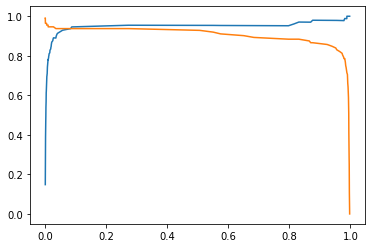

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.95      0.94      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.97       836
weighted avg       0.98      0.98      0.98       836



,Predicted 0,Predicted 1
Actual 0,718,6
Actual 1,7,105


In [77]:
pr2, rc2, thresholds2 = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds2, pr2[1:])
plt.plot(thresholds2, rc2[1:])
plt.show()
crossover_index2 = np.max(np.where(pr2 <= rc2))
crossover_cutoff2 = thresholds2[crossover_index2]
crossover_recall2 = rc2[crossover_index2]

print(classification_report(y_test, y_pred > crossover_cutoff2))

m_confusion_test2 = confusion_matrix(y_test, y_pred > crossover_cutoff2)
display(pd.DataFrame(data = m_confusion_test2, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))


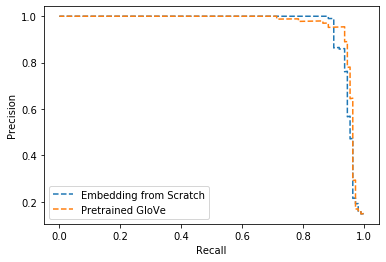

In [82]:
# Plot the precision and recall plot
plt.plot(rc, pr, linestyle='--', label='Embedding from Scratch')
plt.plot(rc2, pr2, linestyle='--', label='Pretrained GloVe')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Term Frequency Inverse Document Frequency (TF-IDF)
Liao, et.al. suggests that TF-IDF features representation is better than the TF representation. 
 
 Reference:
  Liao, C., Alpha, S., "Dixon.P, "Feature Preparation in Text Categorization", Oracle Corporation, 2004. 

In [49]:
# Explore Term Frequency Inverse Document Frequency (TF-IDF) (Source: )
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
vectorizer.transform(x_train).toarray()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [50]:
x_train_vec = vectorizer.transform(x_train).toarray()

In [51]:
model_tdif = svm.SVC(gamma='scale')
model_tdif.fit(x_train_vec, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
x_test_vec = vectorizer.transform(x_test).toarray()

In [53]:
y_pred_tdif = model_tdif.predict(x_test_vec)

In [54]:
print(classification_report(y_test, y_pred_tdif))

m_confusion_test = confusion_matrix(y_test, y_pred_tdif)
display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))

print("This model misclassifies {c} genuine SMS as spam and misses only {d} SPAM.".format(c = m_confusion_test[0,1], d = m_confusion_test[1,0]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.99      0.92      0.95       112

    accuracy                           0.99       836
   macro avg       0.99      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



,Predicted 0,Predicted 1
Actual 0,723,1
Actual 1,9,103


This model misclassifies 1 genuine SMS as spam and misses only 9 SPAM.


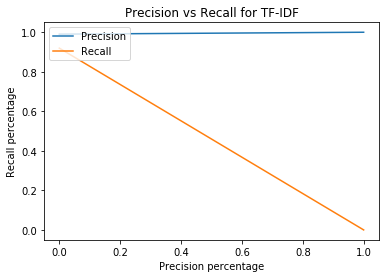

In [65]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred_tdif)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.xlabel("Precision percentage")
plt.ylabel("Recall percentage")
plt.title("Precision vs Recall for TF-IDF")
plt.legend(['Precision','Recall'], loc='upper left')
plt.show()